In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *

import pandas as pd

p = Project.objects.get(pk=341)

q, created = Query.objects.get_or_create(
    title="Climate and Health: y < 2022",
    project=p
)

dids = set(Doc.objects.filter(query=q).values_list('pk', flat=True))
len(dids)

Multicore TSNE not installed, tsne maps will not be able to be calculated
Gensim not installed, you will need this for running Doc2Vec models


960273

In [2]:
regenerate_docinfo = False
if regenerate_docinfo:
    df = pd.DataFrame.from_dict(Doc.objects.filter(pk__in=dids).values('id','PY','title','content','wosarticle__dt'))
    df.columns = ["id","Publication Year","Title","Abstract","Document type"]
    df.head()
    df.to_csv('data/0c_doc_info.csv',index=False)

In [3]:

django.db.connection.close()

dos = DocOwnership.objects.filter(tag__query__project=p, relevant__gt=0)

doc_ids = set(dos.values_list('doc__id',flat=True))

# Get relevant / not relevant decisions
do_df = pd.DataFrame.from_dict(
    dos.values('doc__id','doc__title','doc__content','doc__PY','user__username','relevant')
)
do_df.loc[do_df['relevant']==0,'val'] = np.NaN
do_df.loc[do_df['relevant']==1,'val'] = 1
do_df.loc[do_df['relevant']==2,'val'] = 0
do_df.loc[do_df['relevant']==3,'val'] = np.NaN
do_df.head()

# Get category assignment
cats = Category.objects.filter(project=p).exclude(name__icontains="hidden>")

df = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        category__in=cats,
        doc__in=doc_ids
    ).values(
        'doc__id',
        'doc__title',
        'doc__content',
        'doc__PY',
        'category__name',
        'category__level',
        'user__username',
        'selection_tier'
    )
).drop_duplicates(["doc__id","category__name","user__username"])
# Filter so that it matches the relevant set
df = df[
    (df[['doc__id','user__username']].apply(tuple, axis=1).isin(do_df[['doc__id','user__username']].apply(tuple, axis=1))) | 
    (df['user__username']=="Auto")
]

# Rename category to capture level
df['category__level'] = df['category__level'].astype(str)
df['Category Name'] = df[['category__level','category__name']].apply(lambda x: ' - '.join(x), axis=1)
#df['cat'] = df[['category__level','category__name','user__username']].apply(lambda x: ' - '.join(x), axis=1)

# Capture the primary/secondary value (1 for primary, 2 for secondary)
df['val'] = df['selection_tier']

#df['val'] = df['val'].replace(2,1)

df.head()


,doc__id,doc__title,doc__content,doc__PY,category__name,category__level,user__username,selection_tier,Category Name,val
0,4825235,Inactivation of avian influenza virus by heat ...,Avian influenza viruses threaten the life of d...,2007.0,2.05. Infectious diseases,3,alessandra.landa@outlook.it,1,3 - 2.05. Infectious diseases,1
1,4951588,Comparison of health outcomes from heat-relate...,It is predicted that heat waves will increase ...,2022.0,1.02. Changes in temperature,2,alessandra.landa@outlook.it,1,2 - 1.02. Changes in temperature,1
2,4928918,Health Systems Responsiveness in Addressing In...,Following the 2016 Horse River Wildfire in nor...,2021.0,2.02. Mental health and sentiment,3,alessandra.landa@outlook.it,1,3 - 2.02. Mental health and sentiment,1
3,4825235,Inactivation of avian influenza virus by heat ...,Avian influenza viruses threaten the life of d...,2007.0,2.03. Climate sensitivity,4,alessandra.landa@outlook.it,1,4 - 2.03. Climate sensitivity,1
4,3245360,Characterizing the role of socioeconomic pathw...,Urban dwellers worldwide are increasingly affe...,2019.0,2.05. Scenarios,4,alessandra.landa@outlook.it,1,4 - 2.05. Scenarios,1


In [55]:
import json
scheme = []
for c in Category.objects.filter(project=p, level=1).order_by('name'):
    cs = {
        'name': c.name.replace('<hidden>','').strip(),
        'description': c.description,
        'options': []
    }
    children = Category.objects.filter(parent_category=c)
    for c in children:
        cs['options'].append({
            'name': c.name,
            'description': c.description
        })
    scheme.append(cs)

with open('scheme.json','w') as f:
    #f.write(json.dump(scheme))
    json.dump(scheme, f)

In [47]:
children = Category.objects.filter(parent_category=c)
children

<QuerySet [<Category: 5.02. Biodiversity loss, ecosystem & microbial change>, <Category: 5.03. Reduced agricultural & aquaculture productivity>, <Category: 5.04. Reduced labour and physical capacity>, <Category: 5.01. Pollution>]>

In [32]:
for c in Category.objects.filter(project=p).exclude(name__icontains="hidden>"):
    print(c.name)
    print(c.description)

4.05. Extreme cold
Extreme cold
5.01. Pollution
Pollution
2.08. Mortality and morbidity
Mortality and morbidity
2.04. Extreme event attribution
Health impacts are shown to respond to extreme events
1.04. Changes in precipitation
Changes in precipitation
1.01. CO2 rise
CO2 rise
1.03. Seasonal change
Seasonal change
2.02. Trend attribution
Impact is explicitly attriuted to trends in climate variables
2.06. Other health impacts
Other health impacts
2.05. Scenarios
Evidence is presented on how health impacts will be affected by future climate change
5.02. Biodiversity loss, ecosystem & microbial change
Biodiversity loss, ecosystem & microbial change
5.03. Reduced agricultural & aquaculture productivity
Reduced agricultural & aquaculture productivity
5.04. Reduced labour and physical capacity
Reduced labour and physical capacity
2.01. Food security
Food security
4.04. Other extreme events
Other extreme events
1.06. Climate change (unspecified)
General reference to climate change
1.07. Other

In [30]:
c

'0 - relevant'

In [4]:
# Merge relevant/not relevant with categories
do_df['Category Name'] = "0 - relevant"

merged_df = pd.concat([
    df[['doc__id','doc__title','doc__content','doc__PY','user__username','Category Name','val']],
    do_df[['doc__id','doc__title','doc__content','doc__PY','user__username','Category Name','val']]
])

cats = merged_df['Category Name'].unique()
merged_df.tail()

,doc__id,doc__title,doc__content,doc__PY,user__username,Category Name,val
4899,3779724,Black carbon over an urban atmosphere in north...,Black carbon (BC) has been demonstrated to pos...,2020.0,ari.avallone@gmail.com,0 - relevant,0.0
4900,125689,Forecasting malaria in a highly endemic countr...,Background: Malaria thrives in poor tropical a...,2015.0,ari.avallone@gmail.com,0 - relevant,1.0
4901,611896,Replacing car trips by increasing bike and pub...,Objective: Estimate the health risks and benef...,2012.0,ari.avallone@gmail.com,0 - relevant,0.0
4902,3966499,Prevalence and risk factors for chronic kidney...,Background An epidemic of chronic kidney disea...,2020.0,ari.avallone@gmail.com,0 - relevant,0.0
4903,1489725,Survey Report of Visceral Leishmaniasis Based ...,The paper is based on a population survey cond...,2014.0,ari.avallone@gmail.com,0 - relevant,1.0


In [5]:
cats.sort()
cats

array(['0 - relevant', '2 - 1.01. CO2 rise',
       '2 - 1.02. Changes in temperature', '2 - 1.03. Seasonal change',
       '2 - 1.04. Changes in precipitation', '2 - 1.05. Sea-level rise',
       '2 - 1.06. Climate change (unspecified)',
       '2 - 1.07. Other meteorological variables',
       '3 - 2.01. Food security', '3 - 2.02. Mental health and sentiment',
       '3 - 2.03. Cardiorespiratory disease',
       '3 - 2.04. Direct injury and death',
       '3 - 2.05. Infectious diseases', '3 - 2.06. Other health impacts',
       '3 - 2.07. Water security', '3 - 2.08. Mortality and morbidity',
       '3 - 2.09. Health system capacity',
       '4 - 2.01. Climate change attribution',
       '4 - 2.02. Trend attribution', '4 - 2.03. Climate sensitivity',
       '4 - 2.04. Extreme event attribution', '4 - 2.05. Scenarios',
       '5 - 4.01. Floods and drought', '5 - 4.02. Heatwaves',
       '5 - 4.03. Wildfires', '5 - 4.04. Other extreme events',
       '5 - 4.05. Extreme cold', '6 - 5.01.

In [6]:
# fill tag values with 0s where they have been rated
dudf_wide = (merged_df[['doc__id','doc__title','doc__content','doc__PY','user__username','Category Name','val']]
             .pivot_table(index=['doc__id','doc__title','doc__content','doc__PY','user__username'],columns="Category Name", values="val", aggfunc=np.sum)
             #.fillna(0)
            ).reset_index()

cats = [x for x in cats if x in dudf_wide.columns]

dudf_wide[cats] = dudf_wide[cats].fillna(0)

policy_columns=[x for x in dudf_wide.columns if re.match("^3",x)]
include_policy_columns = [x for x in policy_columns if "not policy related" not in x.lower() and "broader" not in x.lower()]
post_policy_columns=[x for x in dudf_wide.columns if re.match("^[4-9]",x) or re.match("^[0-9]{2}",x)]
#dudf_wide.loc[dudf_wide['3 - 0. Not policy related']==1,post_policy_columns] = np.NaN
dudf_wide.loc[dudf_wide[policy_columns].sum(axis=1,min_count=1)==0,post_policy_columns] = np.NaN

dudf_wide.to_csv('data/0_all_labels.csv',index=False)

dudf_wide.tail()

Category Name,doc__id,doc__title,doc__content,doc__PY,user__username,0 - relevant,2 - 1.01. CO2 rise,2 - 1.02. Changes in temperature,2 - 1.03. Seasonal change,2 - 1.04. Changes in precipitation,...,4 - 2.05. Scenarios,5 - 4.01. Floods and drought,5 - 4.02. Heatwaves,5 - 4.03. Wildfires,5 - 4.04. Other extreme events,5 - 4.05. Extreme cold,6 - 5.01. Pollution,"6 - 5.02. Biodiversity loss, ecosystem & microbial change",6 - 5.03. Reduced agricultural & aquaculture productivity,6 - 5.04. Reduced labour and physical capacity
4507,5682636,Spatial patterns of child growth in Papua New ...,Anthropometric data from the 1982/83 Papua New...,2001.0,ari.avallone@gmail.com,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4508,5682637,Where and why are 10 million children dying ev...,"More than 10 million children die each year, m...",2003.0,alessandra.landa@outlook.it,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4509,5682637,Where and why are 10 million children dying ev...,"More than 10 million children die each year, m...",2003.0,ari.avallone@gmail.com,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4510,5682639,Childhood malnutrition and postwar reconstruct...,Context The 1992 peace settlement that ended t...,1999.0,alessandra.landa@outlook.it,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4511,5682639,Childhood malnutrition and postwar reconstruct...,Context The 1992 peace settlement that ended t...,1999.0,ari.avallone@gmail.com,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dudf_wide.columns

Index(['doc__id', 'doc__title', 'doc__content', 'doc__PY', 'user__username',
       '0 - relevant', '2 - 1.01. CO2 rise',
       '2 - 1.02. Changes in temperature', '2 - 1.03. Seasonal change',
       '2 - 1.04. Changes in precipitation', '2 - 1.05. Sea-level rise',
       '2 - 1.06. Climate change (unspecified)',
       '2 - 1.07. Other meteorological variables', '3 - 2.01. Food security',
       '3 - 2.02. Mental health and sentiment',
       '3 - 2.03. Cardiorespiratory disease',
       '3 - 2.04. Direct injury and death', '3 - 2.05. Infectious diseases',
       '3 - 2.06. Other health impacts', '3 - 2.07. Water security',
       '3 - 2.08. Mortality and morbidity', '3 - 2.09. Health system capacity',
       '4 - 2.01. Climate change attribution', '4 - 2.02. Trend attribution',
       '4 - 2.03. Climate sensitivity', '4 - 2.04. Extreme event attribution',
       '4 - 2.05. Scenarios', '5 - 4.01. Floods and drought',
       '5 - 4.02. Heatwaves', '5 - 4.03. Wildfires',
       '5 - 4.

In [8]:
# Now get a single value for each document by choosing the most common selection
import statistics
def resolve_conflicts(x):
    valid_codes = np.array([y for y in x if pd.notna(y)])
    rounded_codes = np.floor(valid_codes+0.5)
    l = len(set(valid_codes))
    if l==0: # If no valid codes return NA
        return np.NaN, np.NaN
    w = 1 # Sample weight for training - can be reduced by up to a 3rd of maximum by each following condition
    w -= (np.std(rounded_codes) * 2) / 3 # Reduce weight by the amount of substantive disagreement (between 1 and 0)
    w -= (valid_codes==0.5).sum()/valid_codes.shape[0] / 3 # reduce weight by the percentage of labels which were secondary
    rm = np.mean(rounded_codes)
    if rm > 0.5: # overall, a majority coded positive (primary or secondary)
        return 1, w
    elif rm==0.5: # even split, can't decide
        return -1, w
    else: 
        return 0, w
    
# First make it long, so that each row is a doc-category-user rating
xdf = dudf_wide.melt(id_vars=['doc__id','doc__title','doc__content','doc__PY','user__username'])

xdf['value'] = xdf['value'].replace(2,0.5)

# Now group by doc and category, and resolve conflicts
resolved_long = xdf.groupby(['doc__id','doc__title','doc__content','doc__PY','Category Name'])['value'].count().reset_index()
resolved_long['value'], resolved_long['sample_weight'] = zip(*
                                                        xdf.groupby(['doc__id','doc__title','doc__content','doc__PY','Category Name'])['value']
                                                        .agg(lambda x: resolve_conflicts(x))
                                                      )



# Now pivot so that each category is a column
seen_df = resolved_long.drop(columns="sample_weight").pivot(index=["doc__id","doc__title","doc__content","doc__PY"],columns="Category Name").reset_index()
weights_df = resolved_long
weights_df["Category Name"] = weights_df["Category Name"] + "_sample_weight"
weights_df = weights_df.drop(columns="value").pivot(index=["doc__id","doc__title","doc__content","doc__PY"],columns="Category Name").reset_index()
weights_df.columns = [col[1] if col[1] !="" else col[0] for col in weights_df.columns]
weights_df.to_csv('data/0_label_weights.csv',index=False)
print(seen_df.shape)

seen_df.columns = [col[1] if col[1] !="" else col[0] for col in seen_df.columns]

print(seen_df[pd.isna(seen_df['0 - relevant'])].shape)

seen_df.head()

cols_4 = [x for x in seen_df.columns if re.match("^4 -",x)]
seen_df#[seen_df['doc__id']==1828017][["doc__id"]+cols_4]

(1983, 35)
(0, 35)


,doc__id,doc__title,doc__content,doc__PY,0 - relevant,2 - 1.01. CO2 rise,2 - 1.02. Changes in temperature,2 - 1.03. Seasonal change,2 - 1.04. Changes in precipitation,2 - 1.05. Sea-level rise,...,4 - 2.05. Scenarios,5 - 4.01. Floods and drought,5 - 4.02. Heatwaves,5 - 4.03. Wildfires,5 - 4.04. Other extreme events,5 - 4.05. Extreme cold,6 - 5.01. Pollution,"6 - 5.02. Biodiversity loss, ecosystem & microbial change",6 - 5.03. Reduced agricultural & aquaculture productivity,6 - 5.04. Reduced labour and physical capacity
0,3240,Climate Change and Health Research in the East...,"Anthropologically induced climate change, caus...",2010.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7070,Linking health and productivity impacts to cli...,Much of the debate on global climate change ha...,2007.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14576,Emission abatement versus development as strat...,Poorer countries are generally believed to be ...,2005.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20881,Projections of heat waves with high impact on ...,"Climate change will result in more intense, mo...",2014.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21074,Cardiovascular and respiratory mortality attri...,"Ahvaz, the capital city of Khuzestan Province,...",2015.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,5682633,Seasonal aspects of weight-for-age in young ch...,Objective: To identify the season with the hig...,2001.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979,5682634,Undernutrition as an underlying cause of child...,Background: Previous analyses derived the rela...,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,5682636,Spatial patterns of child growth in Papua New ...,Anthropometric data from the 1982/83 Papua New...,2001.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,5682637,Where and why are 10 million children dying ev...,"More than 10 million children die each year, m...",2003.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
for c in seen_df.columns:
    if ' - ' in c:
        print(seen_df.fillna(-1).groupby(c)['doc__id'].count())

0 - relevant
-1.0     184
 0.0    1164
 1.0     635
Name: doc__id, dtype: int64
2 - 1.01. CO2 rise
-1.0      25
 0.0    1947
 1.0      11
Name: doc__id, dtype: int64
2 - 1.02. Changes in temperature
-1.0     107
 0.0    1462
 1.0     414
Name: doc__id, dtype: int64
2 - 1.03. Seasonal change
-1.0      22
 0.0    1952
 1.0       9
Name: doc__id, dtype: int64
2 - 1.04. Changes in precipitation
-1.0      58
 0.0    1774
 1.0     151
Name: doc__id, dtype: int64
2 - 1.05. Sea-level rise
-1.0       4
 0.0    1978
 1.0       1
Name: doc__id, dtype: int64
2 - 1.06. Climate change (unspecified)
-1.0      60
 0.0    1851
 1.0      72
Name: doc__id, dtype: int64
2 - 1.07. Other meteorological variables
-1.0      79
 0.0    1734
 1.0     170
Name: doc__id, dtype: int64
3 - 2.01. Food security
-1.0      41
 0.0    1902
 1.0      40
Name: doc__id, dtype: int64
3 - 2.02. Mental health and sentiment
-1.0      17
 0.0    1898
 1.0      68
Name: doc__id, dtype: int64
3 - 2.03. Cardiorespiratory disease
-

0 - relevant
-1.0     184
 0.0    1164
 1.0     635
dtype: int64

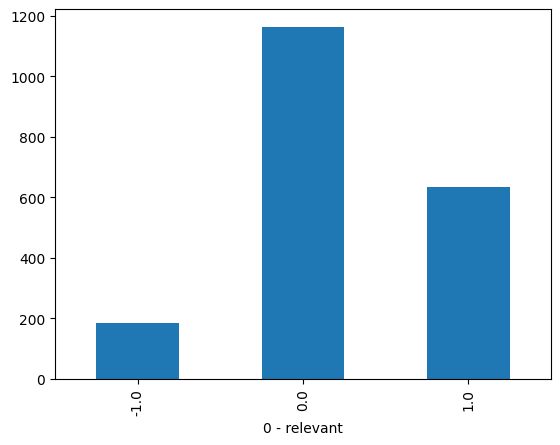

In [10]:
import matplotlib.pyplot as plt

seen_df.fillna(-1).groupby('0 - relevant').size().plot.bar()
seen_df.fillna(-1).groupby('0 - relevant').size()

In [11]:
(resolved_long
 .groupby('sample_weight')['doc__id']
 .count()
 .sort_values(ascending=False)
 .head())

sample_weight
1.000000    44970
0.666667     1334
0.685730     1173
0.574619       38
0.888889       33
Name: doc__id, dtype: int64

In [12]:
cats = list(seen_df.columns)
cats.sort()
cats

['0 - relevant',
 '2 - 1.01. CO2 rise',
 '2 - 1.02. Changes in temperature',
 '2 - 1.03. Seasonal change',
 '2 - 1.04. Changes in precipitation',
 '2 - 1.05. Sea-level rise',
 '2 - 1.06. Climate change (unspecified)',
 '2 - 1.07. Other meteorological variables',
 '3 - 2.01. Food security',
 '3 - 2.02. Mental health and sentiment',
 '3 - 2.03. Cardiorespiratory disease',
 '3 - 2.04. Direct injury and death',
 '3 - 2.05. Infectious diseases',
 '3 - 2.06. Other health impacts',
 '3 - 2.07. Water security',
 '3 - 2.08. Mortality and morbidity',
 '3 - 2.09. Health system capacity',
 '4 - 2.01. Climate change attribution',
 '4 - 2.02. Trend attribution',
 '4 - 2.03. Climate sensitivity',
 '4 - 2.04. Extreme event attribution',
 '4 - 2.05. Scenarios',
 '5 - 4.01. Floods and drought',
 '5 - 4.02. Heatwaves',
 '5 - 4.03. Wildfires',
 '5 - 4.04. Other extreme events',
 '5 - 4.05. Extreme cold',
 '6 - 5.01. Pollution',
 '6 - 5.02. Biodiversity loss, ecosystem & microbial change',
 '6 - 5.03. Redu

In [13]:
# Unresolved
seen_df[seen_df==-1].sum().sum()

-1336.0

In [14]:
# Loop through the comparison/resolution files and resolve labelled dataset
resolutions = pd.DataFrame()

cat_resolver = {
    "3 – 2.08. Mortality and morbidity": "3 - 2.08. Mortality and morbidity",
    "4 – 2.05. Scenarios": '4 - 2.05. Scenarios',
    "6 – 5.01. Pollution": '6 - 5.01. Pollution',
    "5.01. Pollution": '6 - 5.01. Pollution',
    "3 – 2.09. Health system capacity": '3 - 2.09. Health system capacity',
    "3 - 2.05. Infectious Diseases": '3 - 2.05. Infectious diseases',
    "2 - 1.02. Temperature rise": '2 - 1.02. Changes in temperature',
    "4 - 2.03 climate sensitivity": '4 - 2.03. Climate sensitivity',
}

for fname in os.listdir("decision_resolutions"):
    if ".xlsx" in fname:
        try:
            cdf = pd.read_excel(f'decision_resolutions/{fname}',sheet_name="comparison")
        except:
            print(f"Cannot read {fname}")
    dcolumn = [x for x in cdf.columns if "decision" in x.lower()][0]
    cdf = cdf.rename(columns={dcolumn: "decision"})
    cdf = cdf[pd.notna(cdf["decision"])]
    cdf = cdf[cdf['Category Name'].str.match("^[0-9]{1}(?![1-2])")]
    
    cdf['fname'] = fname
    
    resolutions = pd.concat([resolutions, cdf])
    
    for i, row in cdf.iterrows():
        try:
            x = int(row["decision"])
            if x==2:
                x=1
        except:
            print(f"could not parse {row['decision']}")
            continue
        cname = row['Category Name']   
        if cname not in seen_df.columns:
            cname = cat_resolver[cname]
        seen_df.loc[(seen_df['doc__id']==row['doc__id']),cname] = x
        
print(resolutions.shape)
resolutions.to_csv('data/0_conflict_resolutions.csv',index=False)

# Unresolved
seen_df[seen_df==-1].sum().sum()

(2658, 15)


-235.0

In [15]:
# for c in seen_df.columns:
#     if ' - ' in c:
#         print(reldf.groupby(c)['doc__id'].count())

In [16]:


# corrections = pd.read_csv('decision_resolutions/master/corrections.csv', quotechar="'")

# for i, row in corrections.iterrows():
#     try:
#         x = int(row[dcolumn])
#     except:
#         print(f"could not parse {row[dcolumn]}")
#         continue
#     cname = row['Category Name']

#     for r1, r2 in renamings:
#         cname = cname.replace(r1,r2)
#     if cname not in seen_df.columns:
#         matches = [x for x in seen_df.columns if cname.split('. ')[1] in x]
#         if len(matches) == 1:
#             cname = matches[0]
#         else:
#             print(cname)
#             continue

#     seen_df.loc[(seen_df['doc__id']==row['doc__id']),cname] = row[dcolumn]


In [17]:
list(Tag.objects.filter(query__project=p).values_list('title'))

[('all',),
 ('all',),
 ('all',),
 ('Random Test set 2',),
 ('Test set 7',),
 ('Random Test set 3',),
 ('Food set 2',),
 ('Test set 8',),
 ('Food set 1',),
 ('Food refs 2',),
 ('Review refs 1',),
 ('Test set 6',),
 ('Test set 4',),
 ('Food refs 1',),
 ('Random Test set 1',),
 ('Test set 5',),
 ('Test set 1',),
 ('Test set 2',),
 ('Test set 3',)]

In [18]:
# Tag whether the document is part of a representative sample
django.db.connection.close()
seen_df["representative_sample"] = 0
random_tags = Tag.objects.filter(query__project=p, title__icontains="Random")
random_ids = set(DocOwnership.objects.filter(tag__in=random_tags, relevant__gt=0).values_list('doc__id',flat=True))
seen_df.loc[seen_df['doc__id'].isin(random_ids),"representative_sample"] = 1

In [19]:
seen_df['representative_relevant'] = 1
kw_tags = Tag.objects.filter(query__project=p, title__icontains="keyword")
kw_ids = set(DocOwnership.objects.filter(tag__in=kw_tags, relevant__gt=0).values_list('doc__id',flat=True))
seen_df.loc[seen_df['doc__id'].isin(kw_ids),"representative_relevant"] = 0

/tmp/ipykernel_65345/1643552218.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in seen_df.groupby(['representative_sample']):


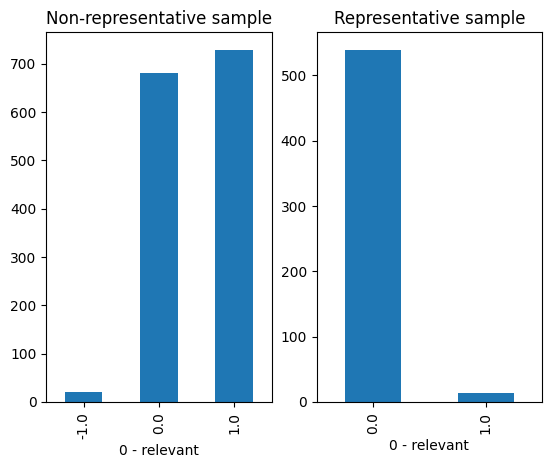

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
labels = ["Non-representative sample","Representative sample"]
for name, group in seen_df.groupby(['representative_sample']):
    ax = axs[name]
    ax.set_title(labels[name])
    group.groupby('0 - relevant').size().plot.bar(ax=ax)

In [21]:
seen_df[seen_df['representative_sample']==1]['0 - relevant'].sum()

13.0

In [22]:
seen_df.rename(
    columns={"doc__id":"id","doc__content":"content","doc__title":"title","doc__PY":"PY"}
).to_csv('data/0_labelled_documents.csv',index=False)

In [23]:
for c in seen_df.columns:
    if ' - ' in c:
        print(seen_df.groupby(c)['doc__id'].count())

0 - relevant
-1.0      20
 0.0    1221
 1.0     742
Name: doc__id, dtype: int64
2 - 1.01. CO2 rise
-1.0       8
 0.0    1964
 1.0      11
Name: doc__id, dtype: int64
2 - 1.02. Changes in temperature
-1.0      23
 0.0    1485
 1.0     475
Name: doc__id, dtype: int64
2 - 1.03. Seasonal change
-1.0       3
 0.0    1963
 1.0      17
Name: doc__id, dtype: int64
2 - 1.04. Changes in precipitation
-1.0       9
 0.0    1779
 1.0     195
Name: doc__id, dtype: int64
2 - 1.05. Sea-level rise
0.0    1981
1.0       2
Name: doc__id, dtype: int64
2 - 1.06. Climate change (unspecified)
-1.0      13
 0.0    1864
 1.0     106
Name: doc__id, dtype: int64
2 - 1.07. Other meteorological variables
-1.0      15
 0.0    1754
 1.0     214
Name: doc__id, dtype: int64
3 - 2.01. Food security
-1.0       7
 0.0    1911
 1.0      65
Name: doc__id, dtype: int64
3 - 2.02. Mental health and sentiment
-1.0       2
 0.0    1902
 1.0      79
Name: doc__id, dtype: int64
3 - 2.03. Cardiorespiratory disease
-1.0      15
 0.

In [24]:
rewrite_unseen = False

if rewrite_unseen:

    columns = [
        'id',
        'content',
        'title',
        'wosarticle__de',
        'wosarticle__wc'
    ]

    unseen_docs = Doc.objects.filter(
        id__in=dids,
        content__iregex='\w',
    ).exclude(pk__in=seen_df['doc__id'])

    unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
    unseen_df = unseen_df[columns]
    unseen_df['relevant'] = 0
    unseen_df['seen'] = 0
    unseen_df['random'] = 0

    print(unseen_df.shape)
    unseen_df.to_feather('data/0_unlabelled_documents.feather')
    unseen_df.head()

In [25]:
seen_df.columns


Index(['doc__id', 'doc__title', 'doc__content', 'doc__PY', '0 - relevant',
       '2 - 1.01. CO2 rise', '2 - 1.02. Changes in temperature',
       '2 - 1.03. Seasonal change', '2 - 1.04. Changes in precipitation',
       '2 - 1.05. Sea-level rise', '2 - 1.06. Climate change (unspecified)',
       '2 - 1.07. Other meteorological variables', '3 - 2.01. Food security',
       '3 - 2.02. Mental health and sentiment',
       '3 - 2.03. Cardiorespiratory disease',
       '3 - 2.04. Direct injury and death', '3 - 2.05. Infectious diseases',
       '3 - 2.06. Other health impacts', '3 - 2.07. Water security',
       '3 - 2.08. Mortality and morbidity', '3 - 2.09. Health system capacity',
       '4 - 2.01. Climate change attribution', '4 - 2.02. Trend attribution',
       '4 - 2.03. Climate sensitivity', '4 - 2.04. Extreme event attribution',
       '4 - 2.05. Scenarios', '5 - 4.01. Floods and drought',
       '5 - 4.02. Heatwaves', '5 - 4.03. Wildfires',
       '5 - 4.04. Other extreme events'